# Inference of parameters with latent variables (SIR model)
In this notebook, we consider the SIR model with symptomatically and asymptomatically infected. We are trying to infer the parameters of the model 

* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), and
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals) 

when given the full data (of classes S, Ia, Is) from a generated trajectory.

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 
from scipy.linalg import eig

## 1) Generate a trajectory
We generate a test trajectory on a population with two ages groups.

In [2]:
M  = 2          # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            # recovery rate of asymptomatic infectives
alpha = np.array([0.5, 0.2])          # fraction of asymptomatic infectives
fsa   = 1          # the self-isolation parameter

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
Ia0 = np.array([20, 20])  # each age group has asymptomatic infectives
Is0 = np.array([20, 20])   # and also symptomatic infectives
R0  = np.array([0, 0])  # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('latent_SIR_traj.npy', data_array)

In [3]:
contactMatrix(0)

array([[18.,  9.],
       [ 3., 12.]])

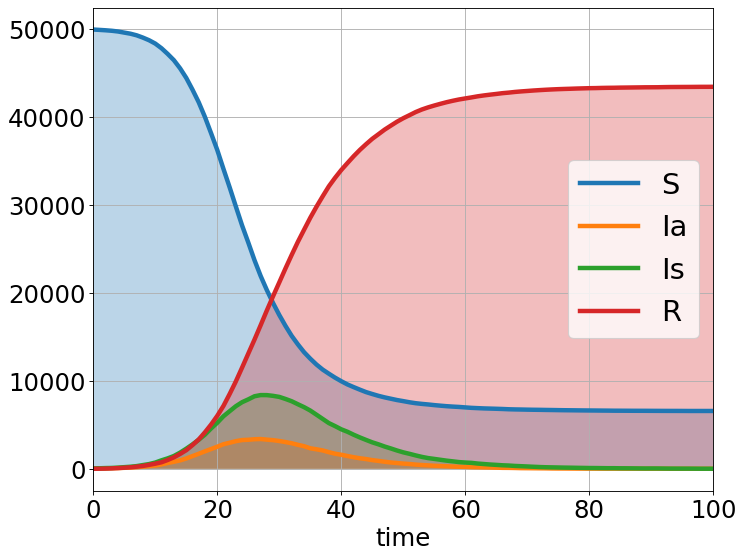

In [4]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
t = data['t']

plt.fill_between(t, 0, np.sum(data_array[:, :M], axis=1),  alpha=0.3)
plt.plot(t, np.sum(data_array[:, :M], axis=1), '-', label='S', lw=4)

plt.fill_between(t, 0, np.sum(data_array[:, M:2*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-', label='Ia', lw=4)

plt.fill_between(t, 0, np.sum(data_array[:, 2*M:3*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-', label='Is', lw=4)

plt.fill_between(t, 0, N - np.sum(data_array[:, :], axis=1), alpha=0.3)
plt.plot(t, N - np.sum(data_array[:, :], axis=1), '-', label='R', lw=4)

plt.legend(fontsize=26)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

## 2) Inference
We take the first $20$ data points of the $I_\mathrm{s}$ trajectory and use it to infer the parameters of the model.

In [5]:
# load the data and rescale to intensive variables 
N_start = 5 
Tf_inference = 15
Nf_inference = Tf_inference + 1

x = np.load('latent_SIR_traj.npy').astype('float')
x = x[N_start:N_start+Nf_inference]

# initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, Ni)

### 2.1) Make a filter for the observed data 
We want a matrix $\boldsymbol{F}$ such that 
$$
\boldsymbol{F}\boldsymbol{x} = \boldsymbol{x}_\mathrm{obs}
$$

In [6]:
# a filter that gives the symptomatic infected
fltr = np.kron([0, 0, 1],np.identity(M))
print(fltr)

[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]


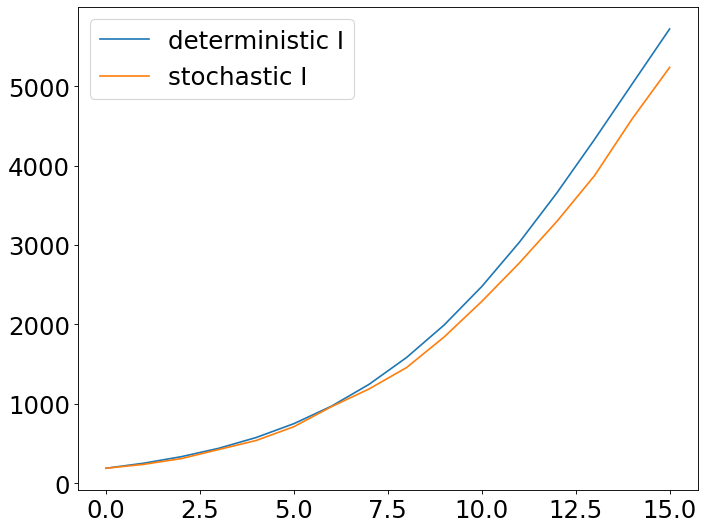

In [7]:
# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
obs=np.einsum('ij,kj->ki', fltr, x)

x0=x[0]

estimator.set_det_model(parameters)
estimator.set_contact_matrix(contactMatrix)
xm = estimator.integrate(x[0], 0, Tf_inference, Nf_inference)
det_obs = np.einsum('ij,kj->ki', fltr, xm)
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(np.sum(det_obs, axis=1), label='deterministic I')
plt.plot(np.sum(obs, axis=1), label='stochastic I')
plt.legend()
plt.show()

In [8]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

logp = estimator.minus_logp_red(parameters, x0, obs, fltr, Tf_inference, contactMatrix, tangent=False)

end_time = time.time()
print(logp) 
print(end_time - start_time)

134.26078062756827
0.26274919509887695


In [13]:
# make parameter guesses and set up bounds for each parameter 
eps=1e-4
param_priors = {
    'alpha':{
        'mean': [0.5, 0.2], 
        'std': [0.05]*2, 
        'bounds': [[eps, 0.5]]*2
    },
    'beta':{
        'mean': 0.04, 
        'std': 0.1,
        'bounds': [eps, 0.4]
    }, 
    'gIa':{
        'mean': 0.13, 
        'std': 0.02, 
        'bounds': [eps, 0.3]
    }, 
    'gIs':{
        'mean': 0.14, 
        'std': 0.05, 
        'bounds': [eps, 0.3]
    }
}

pyross.utils.parse_param_prior_dict(param_priors, M)

Ia0_g = x0[M:2*M]
Ia_std = Ia0_g*5
bounds_for_Ia = np.tile([0.1, 1000], M).reshape(M, 2)

S0_g = x0[:M]# need the sum of S0_g + I0 (observed in this case) over each age group to be smaller than fi 
S_std = Ia_std
bounds_for_S = np.array([(0.1, n-1) for n in Ni]).reshape(M, 2)

init_fltr = np.repeat([True, True, False], M)

init_priors = {
    'independent':{
        'fltr': init_fltr, 
        'mean': [*S0_g, *Ia0_g], 
        'std': [*S_std, *Ia_std], 
        'bounds': [*bounds_for_S, *bounds_for_Ia]
    }
}

# optimisation parameters 
ftol = 1e-8 # the relative tol in (-logp)  

estimator.set_det_method('RK2')
estimator.set_lyapunov_method('euler') # use faster methods 
start_time = time.time()
res = estimator.latent_infer_parameters(obs, fltr, Tf_inference, contactMatrix, param_priors, init_priors, 
                                            tangent=True, global_max_iter=100, global_atol=1, 
                                           cma_processes=1, verbose=True, ftol=ftol,
                                       local_max_iter=1000)
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 9 (seed=2833861713, Wed Jul  1 19:18:15 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 9.657475189613005e+04 1.0e+00 9.23e-01  2e-02  4e+02 0:00.2
    2     32 9.975363592984955e+03 1.3e+00 8.66e-01  2e-02  4e+02 0:00.3
    3     48 2.251693751930088e+02 1.4e+00 9.07e-01  2e-02  4e+02 0:00.5
   26    416 3.382938036583407e+02 3.1e+00 5.23e-01  1e-02  1e+02 0:03.6
   61    976 1.752234171902259e+02 1.5e+01 2.41e-01  3e-03  6e+01 0:07.7
  100   1600 1.423589325466475e+02 9.8e+01 1.84e-01  7e-04  6e+01 0:12.0
Optimal value (global minimisation):  142.35893254664754
Starting local minimisation...
Optimal value (local minimisation):  141.57828582961247
17.030834197998047


In [14]:
# print the correct params and best estimates 
print('True parameters')
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
print(parameters)

best_estimates = res['map_params_dict']
print('\n Best estimates')
print(res['map_params_dict'])

print('\n True initial conditions: ') 
print((x[0]).astype('int'))


map_x0 = res['map_x0']
print('\n Inferred initial conditons: ') 
print(map_x0)

logp = estimator.minus_logp_red(best_estimates, map_x0, obs, fltr, Tf_inference, contactMatrix, tangent=True)

print('\n log p for best estimates:')
print(logp)

True parameters
{'alpha': array([0.5, 0.2]), 'beta': 0.02, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'fsa': 1}

 Best estimates
{'alpha': array([0.48721329, 0.1645973 ]), 'beta': 0.01906868701025412, 'gIa': 0.1292926469524888, 'gIs': 0.13932510195206427, 'fsa': array([1., 1.])}

 True initial conditions: 
[12275 37296    82    31    76   113]

 Inferred initial conditons: 
[1.21411629e+04 3.73045614e+04 9.47405297e+01 2.41076214e-01
 7.60000000e+01 1.13000000e+02]

 log p for best estimates:
132.34566095823072


### 2.2) Plot forecast

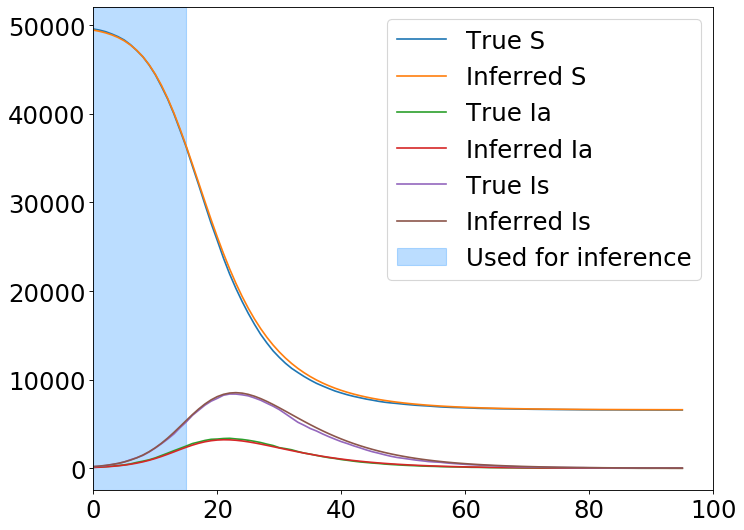

In [17]:
# plot the guessed trajectory and the true trajectory 
estimator.set_params(best_estimates)
estimator.set_det_model(best_estimates)
x_det = estimator.integrate(map_x0, N_start-1, Tf, Nf-N_start, method='LSODA')
x = np.load('latent_SIR_traj.npy').astype('float')[N_start:]
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(np.sum(x[:,0:M], axis=1), label='True S')
plt.plot(np.sum(x_det[:, 0:M], axis=1), label='Inferred S')
plt.plot(np.sum(x[:,1*M:2*M], axis=1), label='True Ia')
plt.plot(np.sum(x_det[:, 1*M:2*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:,2*M:3*M], axis=1), label='True Is')
plt.plot(np.sum(x_det[:, 2*M:3*M], axis=1), label='Inferred Is')
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf])
plt.legend()
plt.show()

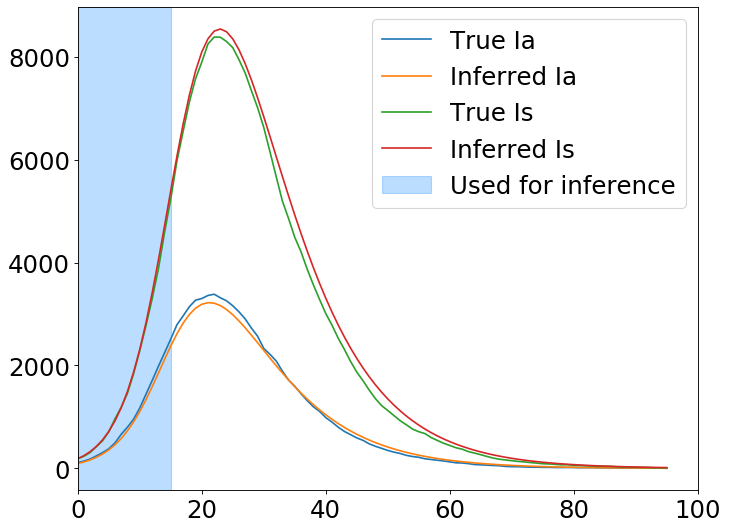

In [18]:
# replot the infected 
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(np.sum(x[:,1*M:2*M], axis=1), label='True Ia')
plt.plot(np.sum(x_det[:, 1*M:2*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:,2*M:3*M], axis=1), label='True Is')
plt.plot(np.sum(x_det[:, 2*M:3*M], axis=1), label='Inferred Is')
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf])
plt.legend()
plt.show()

### 2.3) Compute the Fisher Information matrix (FIM) for inferred epidemiological parameters and initial conditions

In [19]:
# FIM for stochastic model
eps = None
FIM = estimator.FIM(obs, fltr, Tf_inference, contactMatrix,
                   map_dict=res, tangent=True, eps=eps)

# check if FIM is positive definite
evals = np.linalg.eigvals(FIM)
print(np.all(evals >0))

evals

eps-vector used for differentiation:  [7.45058060e-09 5.26835606e-09 1.86264515e-09 5.26835606e-09
 5.26835606e-09 1.34869915e-06 2.69739830e-06 1.19209290e-07
 5.26835606e-09]
False


array([ 2.27970324e+07,  7.17516219e+03,  3.51042476e+03,  3.02738237e+02,
        1.00904443e+01,  3.44613634e-04, -4.46535011e-05,  1.30510719e-06,
        7.14903475e-08])

In [20]:
# FIM for deterministic model
FIM_det = estimator.FIM_det(obs, fltr, Tf_inference, contactMatrix,
                   map_dict=res,eps=eps, measurement_error=1e-2)

# check if FIM_det is positive definite
evals_det = np.linalg.eigvals(FIM_det)
print(np.all(evals_det >0))

evals_det

eps-vector used for differentiation:  [7.45058060e-09 5.26835606e-09 1.86264515e-09 5.26835606e-09
 5.26835606e-09 1.34869915e-06 2.69739830e-06 1.19209290e-07
 5.26835606e-09]
False


array([ 1.95497927e+16,  4.74566463e+11,  1.20996445e+11,  7.19168055e+09,
       -3.66687902e+08,  6.14524100e+07,  6.22019107e+04, -2.81604551e+01,
       -5.43997466e+02])